<table>
<tr><td><img style="height: 150px;" src="images/geo_hydro1.jpg"></td>
<td bgcolor="#FFFFFF">
    <p style="font-size: xx-large; font-weight: 900; line-height: 100%">AG Dynamics of the Earth</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Juypter notebooks</p>
    <p style="font-size: large; color: rgba(0,0,0,0.5);">Georg Kaufmann</p>
    </td>
</tr>
</table>

# Numerical methods: 7. Linear systems
## Sparse systems
----
*Georg Kaufmann,
Geophysics Section,
Institute of Geological Sciences,
Freie Universität Berlin,
Germany*

In this notebook, we discuss matrix storage for larger systems of linear equations.
Here, storing a full $ n \times n$ matrix becomes inefficient.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.linalg
import scipy.sparse
from sys import getsizeof

----
## Compressed row storage

We follow here the [wikipedia](https://de.wikipedia.org/wiki/Compressed_Row_Storage) entry 
to **compressed row storage**, a method to keep only the **non-zero** entries of a matrix in memory.

Consider the 4x5-matrix:

$$
A=
  \begin{pmatrix} 
    \underset{({\color{Blue}0},{\color{Green}0})}{10} & 0 & 0 & \underset{({\color{Blue}0},{\color{Green}3})}{12} & 0 \\ 
    0 & 0 & \underset{({\color{Blue}1},{\color{Green}2})}{11} & 0 & \underset{({\color{Blue}1},{\color{Green}4})}{13} \\
    0 & \underset{({\color{Blue}2},{\color{Green}1})}{16} & 0 & 0 & 0 \\
    0 & 0 & \underset{({\color{Blue}3},{\color{Green}2})}{11} & 0 & \underset{({\color{Blue}3},{\color{Green}4})}{13} \\
  \end{pmatrix}
$$
In every row, we have only one or two non-zero entries, which we store in a 1D array:
$$
A_{sparse} = \left( 10, 12, 11, 13, 16, 11, 13 \right)
$$
We then need to use to integer arrays to store the locations of the non-zeros entries.
Ther first array, $icol$, markes the column positions of each entry (the green enties above):
$$
icol = \left( 0,3,2,4,1,2,4 \right)
$$
To identify, to which row these colunm indices belong, a second integer array $irow$ is used:
$$
irow = \left( 0,2,4,5,7 \right)
$$
This array marks the starting position of column entries for a specific row in $icol$.

We recover the positions for the non-zero entries with a small `python` script:

In [2]:
Awiki = np.array([10,12,11,13,16,11,13])
icol = np.array([0,3,2,4,1,2,4])
irow = np.array([0,2,4,5,7])

print('i j A[i,j]')
for i in range(len(irow)-1):
    for j in range(irow[i],irow[i+1]):
        print(i,icol[j],Awiki[j])

i j A[i,j]
0 0 10
0 3 12
1 2 11
1 4 13
2 1 16
3 2 11
3 4 13


----
## Example of full random matrix

We create a $n \times n$ matrix $A$ with random entries and a right-hand side vector $b$,
also filled with random values. Note that we fixed the random seed to replicate the random numbers.

We use the `plr.spy` routine from `matplotlib` to visualise the storage of non-zero
elements of the matrix A.

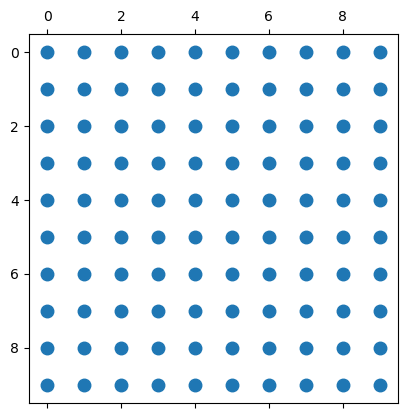

In [3]:
n = 10
np.random.seed(11)
A = np.random.random(n*n).reshape(n,n)
b = np.random.random(n)

plt.spy(A,marker='o', markersize=9)

We solve this random system with `solve` from the `scipy.linalg` package (which is similar to the
one in the `numpy` package).

In [4]:
x = scipy.linalg.solve(A,b)
print('x:\n',x)
print(np.allclose(np.dot(A,x),b))

x:
 [ 0.1624288   0.72867894 -0.23907319  0.27706038 -1.89521534  0.36190807
 -0.70006475  0.36629743 -0.46594217  1.26300196]
True


We check to storage size occupied by matrix $A$ with `getsize` from the `sys` package:

In [5]:
print(getsizeof(A),' bytes')

128  bytes


----
## Example with banded matrix

Next, we create a **banded matrix** with 
- the main diagonal filled with $1$,
- both first side diagonals filled with $-2$,
- otherwise entries are zero.

We use `np.ones`first to create an 1D array with the non-zero values for each diagonal,
then expand these non-zero entries into a 2D array, using `np.diag`.

In [6]:
print(np.ones(n))
print(np.diag(np.ones(n)))

[1. 1. 1. 1. 1. 1. 1. 1. 1. 1.]
[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]]


928  bytes


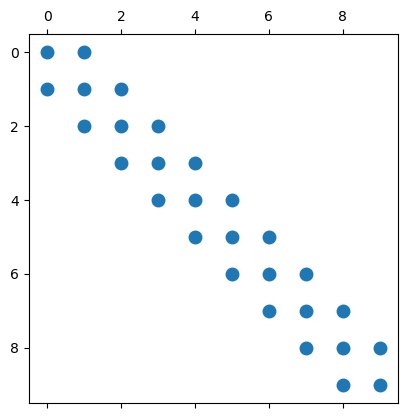

In [7]:
np.random.seed(11)
A = np.diag(-2*np.ones(n)) + np.diag(np.ones(n-1),k=1) + np.diag(np.ones(n-1),k=-1)
b = np.random.random(n)
plt.spy(A,marker='o', markersize=9)

print(getsizeof(A),' bytes')

We solve this banded system again with `solve` from the `scipy.linalg` package (which is similar to the
one in the `numpy` package).

In [8]:
x = scipy.linalg.solve(A,b)
print('x:\n',x)
print(np.allclose(np.dot(A,x),b))

x:
 [-1.81402394 -3.4477782  -5.06205721 -6.2131177  -6.63924425 -6.6451672
 -6.16566306 -5.6733781  -4.69372153 -2.77225831]
True


----
## Sparse storage and sparse solver

We rearrange the banded matrix $A$ into a **compressed row storage**, using the
`csr_matrix` routine from the `scipy.sparse` package.

With `print()`, we check to sparse matrix, and with the function `toarray()`, we can convert
it back to full storage (which we need for the check of the solution later ...).

48  bytes
A:
   (0, 0)	-2.0
  (0, 1)	1.0
  (1, 0)	1.0
  (1, 1)	-2.0
  (1, 2)	1.0
  (2, 1)	1.0
  (2, 2)	-2.0
  (2, 3)	1.0
  (3, 2)	1.0
  (3, 3)	-2.0
  (3, 4)	1.0
  (4, 3)	1.0
  (4, 4)	-2.0
  (4, 5)	1.0
  (5, 4)	1.0
  (5, 5)	-2.0
  (5, 6)	1.0
  (6, 5)	1.0
  (6, 6)	-2.0
  (6, 7)	1.0
  (7, 6)	1.0
  (7, 7)	-2.0
  (7, 8)	1.0
  (8, 7)	1.0
  (8, 8)	-2.0
  (8, 9)	1.0
  (9, 8)	1.0
  (9, 9)	-2.0
A:
 [[-2.  1.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 1. -2.  1.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  1. -2.  1.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  1. -2.  1.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  1. -2.  1.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  1. -2.  1.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  1. -2.  1.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  1. -2.  1.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  1. -2.  1.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  1. -2.]]
b:
 [0.18026969 0.01947524 0.46321853 0.72493393 0.4202036  0.4854271
 0.01278081 0.48737161 0.94180665 0.85079509]


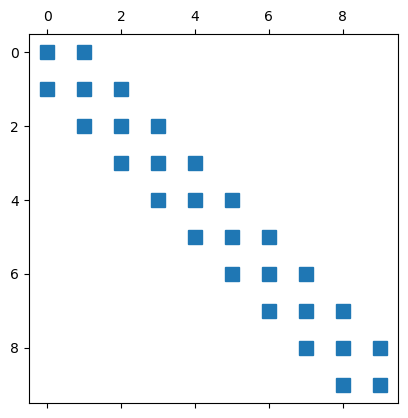

In [9]:
Asparse = scipy.sparse.csr_matrix(A)
print(getsizeof(Asparse),' bytes')
print('A:\n',Asparse)
print('A:\n',Asparse.toarray())
print('b:\n',b)

plt.spy(Asparse)

In [10]:
x =scipy.sparse.linalg.spsolve(Asparse,b)
print('x:\n',x)
print(np.allclose(np.dot(Asparse.toarray(),x),b))

x:
 [-1.81402394 -3.4477782  -5.06205721 -6.2131177  -6.63924425 -6.6451672
 -6.16566306 -5.6733781  -4.69372153 -2.77225831]
True


----
## Check the wikipedia example ...

In [11]:
A = np.array([[10,0,0,12,0],[0,0,11,0,13],[0,16,0,0,0],[0,0,11,0,13]])
Asparse = scipy.sparse.csr_matrix(A)
print(Asparse)

  (0, 0)	10
  (0, 3)	12
  (1, 2)	11
  (1, 4)	13
  (2, 1)	16
  (3, 2)	11
  (3, 4)	13


----
## Condition number

Test the **condition number** of a matrix. Use as example
$$
A = \left[
\begin{array}{cc}
1 & 2 \\
1.0001 & 2
\end{array}
\right]
$$
The condition number $K$ can be calculated from the matrix norm:
$$
K(A) = ||A|| \cdot ||A^{-1}||
$$
Here, as norm, the $l_2$ norm, the $l_{\infty}$ norm, or another norm can be used.

In [24]:
A = np.array([[1,2],[1.0001,2]],dtype=float)
K    = np.linalg.cond(A)
K2   = np.linalg.cond(A,2)
Kinf = np.linalg.cond(A,np.inf)

print('K: ',round(K,2), ' default, L2 norm')
print('K: ',round(K2,2),' L2 norm')
print('K: ',round(Kinf,2),' Linfty norm')

K:  50001.0  default, L2 norm
K:  50001.0  L2 norm
K:  60002.0  Linfty norm


[next>](Numerics_lab07_lu.ipynb)